# Settings

In [1]:
## Patch for annotations in R4.1
# BiocManager::install("Bioconductor/GenomeInfoDb",lib = "/home/luca/R/x86_64-pc-linux-gnu-library/4.1",force = TRUE)
# library(GenomeInfoDb,lib.loc="/home/luca/R/x86_64-pc-linux-gnu-library/4.1")

In [2]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix, tidyverse,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX,
               EnsDb.Hsapiens.v86, fgsea,
               logr, parallel, DESeq2,
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x)

In [3]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

In [8]:
# Set directories
assets.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Assets/"

step1.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/"
step2.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/"

counts.dir = paste0(step2.dir, "ATAC/4Chambers/COUNTS/")
DESEQ.dir = paste0(step2.dir, "ATAC/4Chambers/DESEQ/")

# DESeq2 - HF status

In [9]:
meta = read.table(paste(assets.dir, "multiome_metadata_LA_cellnumbers.txt", sep = ""))
head(meta, n = 2)
meta$Age.scaled = scale(meta$Age)
colnames(meta)

meta$HF_status = meta$HF_status_base

,donor,condition,HF_status_base,HF_status,Diabetes_status,Age,Sex,Height,Weight,BMI,⋯,aCM,Lymphoid,Epicardial,Neuronal,SM,Adipocyte,Height.scaled,Weight.scaled,BMI.scaled,Age.scaled
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,D35,CONTROL,NON_HF,NON_HF,NDM,20,male,175.0,77.0,25.1,⋯,479,65,1,35,149,0,0.1654396,-0.3470442,-0.4593617,-2.3804568
2,D36,CONTROL,NON_HF,NON_HF,NDM,42,female,154.9,70.4,29.3,⋯,341,128,203,71,380,5,-1.2849828,-0.6857574,0.4000232,-0.8551155


[1] "donor"           "condition"       "HF_status_base"  "HF_status"      
 [5] "Diabetes_status" "Age"             "Sex"             "Height"         
 [9] "Weight"          "BMI"             "Fibroblast"      "Myeloid"        
[13] "Pericyte"        "Endocardial"     "Endothelial"     "aCM"            
[17] "Lymphoid"        "Epicardial"      "Neuronal"        "SM"             
[21] "Adipocyte"       "Height.scaled"   "Weight.scaled"   "BMI.scaled"     
[25] "Age.scaled"

In [10]:
#Pseudobulk matrices directory
dir <- counts.dir
#Create outdir for results
outdir <- DESEQ.dir
# dir.create(outdir)
#Get list of pseudobulk files
files <- list.files(dir, pattern='_perdonor.ATAC.counts')
#Cut off file suffices to get celltype names
cells <- gsub('_perdonor.ATAC.counts','', files) 

In [11]:
files
cells

[1] "aCM_perdonor.ATAC.counts"         "Adipocyte_perdonor.ATAC.counts"  
 [3] "Endocardial_perdonor.ATAC.counts" "Endothelial_perdonor.ATAC.counts"
 [5] "Epicardial_perdonor.ATAC.counts"  "Fibroblast_perdonor.ATAC.counts" 
 [7] "Lymphoid_perdonor.ATAC.counts"    "Myeloid_perdonor.ATAC.counts"    
 [9] "Neuronal_perdonor.ATAC.counts"    "Pericyte_perdonor.ATAC.counts"   
[11] "SM_perdonor.ATAC.counts"          "vCM_perdonor.ATAC.counts"

[1] "aCM"         "Adipocyte"   "Endocardial" "Endothelial" "Epicardial" 
 [6] "Fibroblast"  "Lymphoid"    "Myeloid"     "Neuronal"    "Pericyte"   
[11] "SM"          "vCM"

In [12]:
# List your contrasts  
conditions.1 = c("HF") # disease
conditions.2 = c("NON_HF") # control
contrasts = c(paste0(conditions.1, "_vs_", conditions.2))

# Write your formual
deseq.formula <- as.formula('~ Sex + HF_status') # last variable is the testing variable

In [13]:
deseq.stats = NULL

for (i in seq_along(files)) {
    file.use = files[i]
    cell.use = cells[i]
    print(paste0("Analyzing: ", cell.use))
    raw_counts <- read.table(paste0(dir, file.use), header = TRUE, row.names = 1)
    # Filter for only samples with any counts in the cell type
    raw_counts = raw_counts[, (colSums(raw_counts != 0) > 0)]
    message("Donors detectected with celltype: ", ncol(raw_counts))
    meta_cell <- subset(meta, donor %in% colnames(raw_counts))
    rownames(meta_cell) = meta_cell$donor
    message("subsetting metadata accordingly - Check that value is equal to above: ", nrow(meta_cell))
    # Ensure that the column names of raw_counts are in the same order as the library identifiers in meta_cell
    meta_cell <- meta_cell[match(colnames(raw_counts), rownames(meta_cell)), ]
    
    for (c.i in seq_along(contrasts)) {
        contrast.use = contrasts[c.i]
        condition.1 = conditions.1[c.i]
        condition.2 = conditions.2[c.i]
        message("  - ", contrast.use)

        # Create vectors of samples for each condition
        samples.condition.1 <- meta_cell %>% 
                               dplyr::filter(HF_status %in% condition.1) %>% 
                               pull(donor)
        samples.condition.2 <- meta_cell %>% 
                               dplyr::filter(HF_status %in% condition.2) %>% 
                               pull(donor)
        
        # Subset meta_cell for the current contrast
        meta_cell.use <- meta_cell %>% 
                     dplyr::filter(donor %in% c(samples.condition.1, samples.condition.2)) 
        rownames(meta_cell.use) <- meta_cell.use$donor
        
        # Subset raw_counts for the donors in meta_cell
        raw_counts_subset <- raw_counts[, colnames(raw_counts) %in% rownames(meta_cell.use)]

        # Ensure that the column names of raw_counts are in the same order as the library identifiers in meta_cell
        meta_cell.use <- meta_cell.use[match(colnames(raw_counts_subset), rownames(meta_cell.use)), ]
        
        # Check if enough samples are present for both conditions
        if (length(unique(meta_cell$HF_status)) >= 2) {
            tryCatch({
            deseq.stats.tmp <- data.frame()
            # Light pre-filtering
            counts_filtered <- raw_counts_subset[rowSums(raw_counts_subset) >= 10,]

            # Run DESeq2
            dds <- DESeqDataSetFromMatrix(countData = round(counts_filtered),
                                          colData = meta_cell.use, 
                                          design = deseq.formula)
            dds$HF_status <- relevel(dds$HF_status, ref = condition.2)
            dds <- DESeq(dds)
            dds.results <- results(dds)
            dds.results <- na.omit(dds.results[order(dds.results$padj), ])

            # Write DESeq results to file
            write.table(dds.results, 
                        file = paste0(outdir, cell.use, "_", contrast.use, ".dds.res"), 
                        sep = '\t', quote = FALSE)
            
            # Collect summary statistics
            deseq.stats.tmp <- data.frame(
                celltype = cell.use,
                contrast = contrast.use,
                up_pval = sum(dds.results$log2FoldChange > 0 & dds.results$pvalue < 0.05),
                down_pval = sum(dds.results$log2FoldChange < 0 & dds.results$pvalue < 0.05),
                up_padj = sum(dds.results$log2FoldChange > 0 & dds.results$padj < 0.1),
                down_padj = sum(dds.results$log2FoldChange < 0 & dds.results$padj < 0.1))
                deseq.stats <- rbind(deseq.stats, deseq.stats.tmp)

                           # Make Volcano plot - Padj
                            res = as.data.frame(dds.results)
                            res$SYMBOL = rownames(res)
                            res = res %>%
                            dplyr::filter(!is.na(SYMBOL)) %>%
                            dplyr::filter(padj < 0.1) %>%
                            dplyr::group_by(sign(log2FoldChange)) %>%
                            dplyr::mutate(rank = abs(log2FoldChange) * -log10(padj)) %>%
                            dplyr::top_n(50, rank) %>%
                            dplyr::mutate(delabel = SYMBOL) %>%
                            ungroup() %>%
                            dplyr::select(delabel, SYMBOL) %>%
                            right_join(res) %>%
                            dplyr::mutate(delabel = if_else(is.na(delabel), "", as.character(delabel))) 

                            # Add a new column for color based on significance and direction
                            res$changes <- ifelse(res$log2FoldChange > 0 & res$padj < 0.1, "Up-regulated",
                                                ifelse(res$log2FoldChange < 0 & res$padj < 0.1, "Down-regulated", "NS"))
                            # Get the number of upregulated and downregulated genes
                            n_up <- sum(res$changes == "Up-regulated")
                            n_down <- sum(res$changes == "Down-regulated")

                            # Modify log2FoldChange values to be max x
                            res$log2FoldChange[res$log2FoldChange > 10] <- 10
                            res$log2FoldChange[res$log2FoldChange < -10] <- -10
                            # Modify padj values to be max x 
                            res$padj[res$padj < 10^-200] <- 10^-200
                    
                            plot = ggplot(res, aes(x=log2FoldChange, y=-log10(padj), label=delabel, color=changes)) +
                                theme_bw() +
                                labs(y="-log10(padj)", x="log2FoldChange", 
                                   title=paste(cell.use, " - ",
                                               condition.1, "Vs", condition.2, "\n",
                                              "Up: ", n_up, "-",
                                               "Down: ", n_down)) +
                                geom_point() +
                                scale_color_manual(values=c("blue", "grey", "red")) + 
                                theme(axis.text=element_text(size=16), axis.title=element_text(size=16, face="bold"),
                                    axis.text.x=element_text(), plot.title=element_text(size=18, face="bold", hjust=0.5)) +
                                scale_x_continuous(breaks=c(-10, -5, 0, 5, 10),
                                            labels=c("< -10", "-5", "0", "5", "> 10"), lim = c(-10, 10))+
                                scale_y_continuous(breaks=c(0, 20, 40, 60, 80, 100, 200),
                                            labels=c("0", "20", "40", "60", "80", "100", ">200"))+
                                geom_text_repel(label=res$delabel, size=3.5, max.overlaps=10,
                                              point.padding=0, min.segment.length=0,
                                              max.time=20, max.iter=1e5, box.padding=0.3)
                    
                            ggsave(filename = paste0(outdir, cell.use, "_", contrast.use, ".volcanoPlot.pdf"),
                                   height = 10, width = 10,
                                   plot = plot, device = "pdf")
            }, error = function(e) {
                message("Error in DESeq2 processing for ", cell.use, " ", contrast.use, ": ", e$message)
            })
        } else {
            message("Not enough samples for contrast: ", contrast.use)
        }
    }
}

[1] "Analyzing: aCM"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 131 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Adipocyte"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 127 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Endocardial"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 94 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Endothelial"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 74 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Epicardial"


Donors detectected with celltype: 28

subsetting metadata accordingly - Check that value is equal to above: 28

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

Error in DESeq2 processing for Epicardial HF_vs_NON_HF: every gene contains at least one zero, cannot compute log geometric means



[1] "Analyzing: Fibroblast"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 42 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Lymphoid"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 9 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Myeloid"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 8 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Neuronal"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 4 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: Pericyte"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 5 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: SM"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 13 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


[1] "Analyzing: vCM"


Donors detectected with celltype: 30

subsetting metadata accordingly - Check that value is equal to above: 30

  - HF_vs_NON_HF

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 60 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Joining with `by = join_by(SYMBOL)`


In [14]:
deseq.stats

celltype,contrast,up_pval,down_pval,up_padj,down_padj
<chr>,<chr>,<int>,<int>,<int>,<int>
aCM,HF_vs_NON_HF,12027,8630,4556,3247
Adipocyte,HF_vs_NON_HF,576,444,0,0
Endocardial,HF_vs_NON_HF,2404,1631,290,86
Endothelial,HF_vs_NON_HF,5958,4230,2771,1502
Fibroblast,HF_vs_NON_HF,15682,16112,11522,12418
Lymphoid,HF_vs_NON_HF,1028,836,7,12
Myeloid,HF_vs_NON_HF,6977,7102,3308,3067
Neuronal,HF_vs_NON_HF,1150,753,158,87
Pericyte,HF_vs_NON_HF,3638,3147,1237,1201


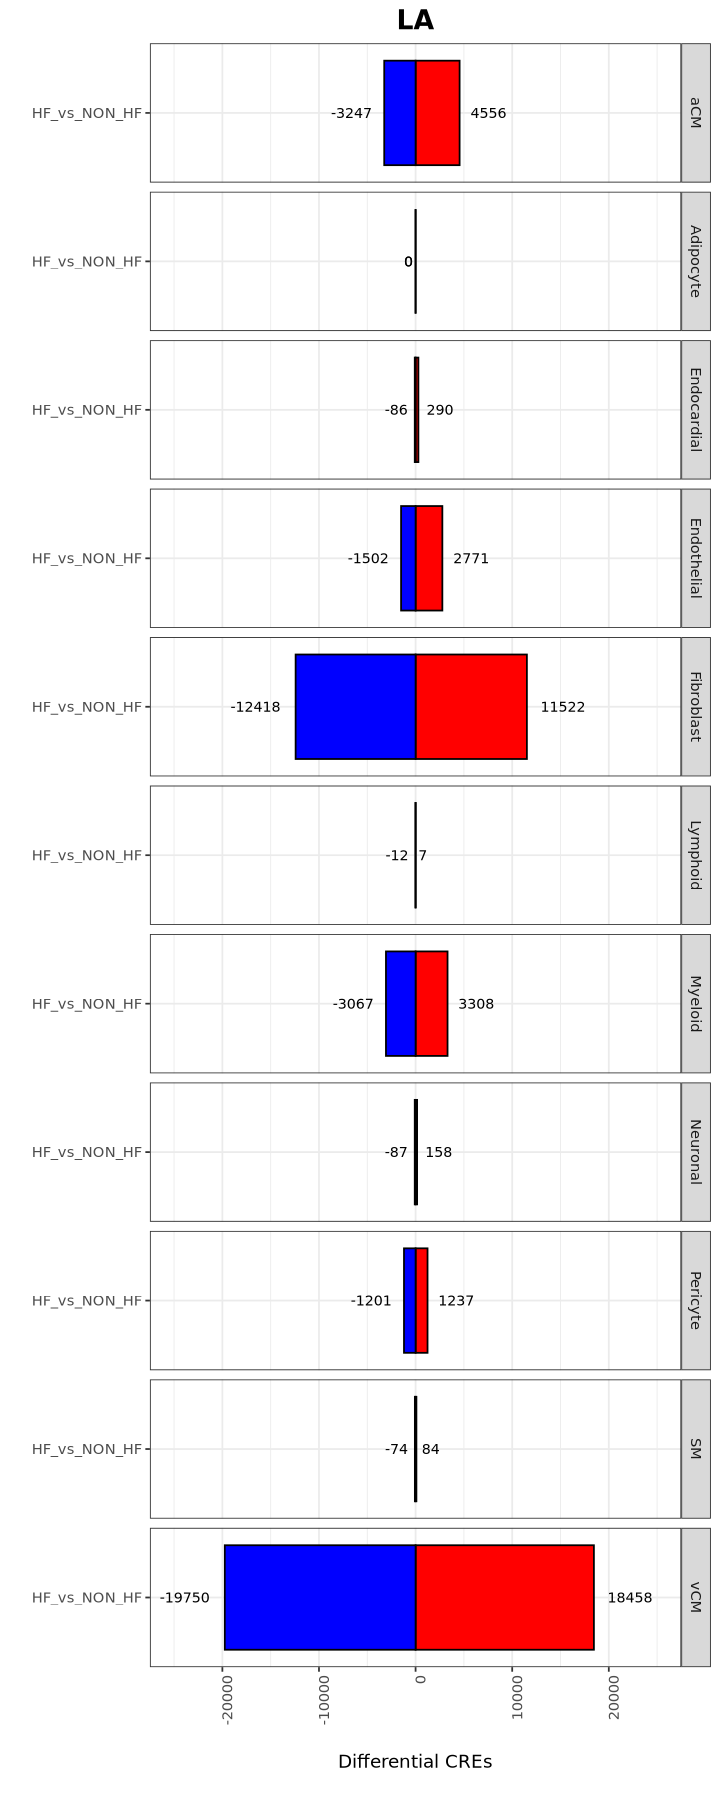

In [15]:
deseq.stats.plot = deseq.stats %>%
                  dplyr::select(celltype, contrast, up_padj, down_padj) %>%
                  pivot_longer(
                    cols = c(up_padj, down_padj),
                    names_to = "direction",
                    names_pattern = "([^_]+)_.*", # Captures everything before the underscore
                    values_to = "degenes") %>%
                 dplyr::mutate(direction = factor(direction, levels = c("up", "down")),
                              contrast = factor(contrast, levels = contrasts)) %>%
                 dplyr::mutate(degenes = if_else(direction == "down", -degenes, degenes))


options(repr.plot.width=6, repr.plot.height=15)
width = 1
# Plot with dynamic text positioning based on the sign of degenes
ggplot(deseq.stats.plot, aes(x = contrast, y = degenes, fill = direction, label = degenes)) +
  geom_bar(stat = "identity", color = "black") +
  scale_fill_manual(values = c("up" = "red", "down" = "blue")) + 
  theme_bw() +
  labs(title = "LA", x = "", y = " \n Differential CREs \n ") +
  ylim(-25000, 25000) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1),
        legend.position = "none", 
        plot.title = element_text(hjust = 0.5, face = "bold", size = 16)) +  
  geom_text(aes(hjust = ifelse(degenes > 0, -0.3, 1.3)),
            size = 3) +
  facet_nested(rows = vars(celltype), scales = "free", space = "free") +
  coord_flip()

In [16]:
write.table(deseq.stats, 
            paste0(outdir, "HFnonHF_ResultsSummaries.tsv"),
           quote=F, col.names=T, row.names=T, sep='\t')